In [1]:
import os
import skimage.io
import skimage.transform
import numpy as np
import matplotlib.pyplot as plt
import quaternion
from tqdm import tqdm
import cv2
import torch
from torch import nn

from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    RasterizationSettings,
    MeshRenderer, 
    MeshRasterizer,  
    HardFlatShader,
    TexturesUV
)
from pytorch3d.renderer.blending import BlendParams

import sys; sys.path.append('../')
from mmf.neural_rendering.perspective_shader import SoftRGBDShader
from mmf.neural_rendering.mesh_unrenderer import (
    MeshUnrenderer, SoftPerspectiveUnshader, GaussianSplatter
)

In [2]:
# Camera and rasterization parameters
image_size = 960
blur_radius = 1e-12
faces_per_pixel = 1
HFOV = 45  # dummy parameter here. We will adjust via the absolute depth scaling factor

# Blending parameters
sigma = 1e-6
gamma = 1e-4
z_background = 1

# Gaussian_blurring parameters
gblur_kernel_size = 7
gblur_sigma = 2.
gblur_weight_thresh = 1e-4

# GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

depth_scaling = 16000
min_inv_depth = 800
H_mesh = 129
W_mesh = 129
eps = 1e-2

image_file = './oxford.jpg'

## Get externally-predicted depth from MiDaS

In [3]:
# Load the MiDaS model
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS").to(device).eval()
transform = torch.hub.load("intel-isl/MiDaS", "transforms").default_transform

# pad the input image to a square size (image_size, image_size)
# as PyTorch3d v2.0.5 can only handle square inputs
img_raw = skimage.io.imread(image_file)
orig_H, orig_W = img_raw.shape[:2]
scale = image_size / max(orig_H, orig_W)
new_H, new_W = int(round(orig_H * scale)), int(round(orig_W * scale))
img_raw = skimage.img_as_ubyte(skimage.transform.resize(img_raw, (new_H, new_W)))
# compute the padding
pad_h0 = (image_size - new_H) // 2
pad_h1 = image_size - new_H - pad_h0
pad_w0 = (image_size - new_W) // 2
pad_w1 = image_size - new_W - pad_w0
end_h1 = None if pad_h1 == 0 else -pad_h1
end_w1 = None if pad_w1 == 0 else -pad_w1
padding = (pad_h0, pad_h1, pad_w0, pad_w1)
# pad the image
img_pad = 255 * np.ones((image_size, image_size, 3), dtype=img_raw.dtype)
img_pad[pad_h0:end_h1, pad_w0:end_w1] = img_raw
im = skimage.img_as_float(img_pad)

# get inverse depth map from MiDaS
input_batch = transform(img_raw).to(device)
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img_raw.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

# also pad the output depth map to a square size (image_size, image_size) 
output_inv_depth_crop = np.clip(prediction.cpu().numpy(), a_min=0, a_max=None)
output_inv_depth = -np.ones((image_size, image_size), dtype=np.float32)
output_inv_depth[pad_h0:end_h1, pad_w0:end_w1] = output_inv_depth_crop
inv_depth = np.maximum(min_inv_depth, output_inv_depth)
depth = depth_scaling / inv_depth

Using cache found in /private/home/ronghanghu/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /private/home/ronghanghu/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /private/home/ronghanghu/.cache/torch/hub/intel-isl_MiDaS_master


## Show the image and (externally predicted) depth map

Text(0.5, 1.0, 'depth map')

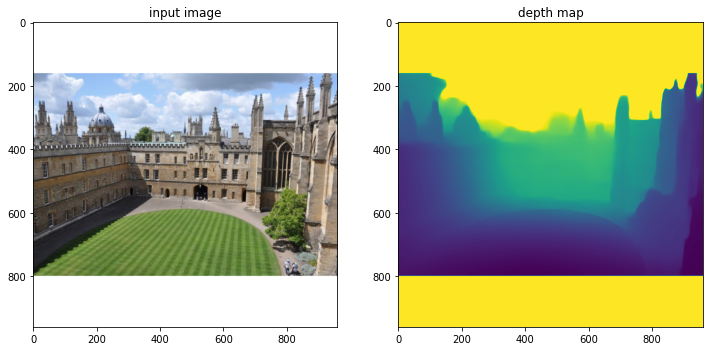

In [4]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('input image')
plt.subplot(1, 2, 2)
plt.imshow(depth)
plt.title('depth map')

## Prepare the mesh and utilities for image forwarding

In [5]:
raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=blur_radius,
    faces_per_pixel=faces_per_pixel,
    perspective_correct=True,
    clip_barycentric_coords=False,
)

blend_params = BlendParams(
    sigma=sigma, gamma=gamma, background_color=(1, 1, 1)
)

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader=SoftRGBDShader(
        blend_params=blend_params, device=device, z_background=z_background
    )
)

splatter = GaussianSplatter(
    channels=3,
    kernel_size=gblur_kernel_size,
    sigma=gblur_sigma,
    weight_thresh=gblur_weight_thresh
).to(device)

unrenderer = MeshUnrenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    unshader=SoftPerspectiveUnshader(
        blend_params=blend_params, device=device, texture_splatter=splatter
    )
)

R_init = np.eye(3)
T_init = np.zeros(3)
cameras_view_a = FoVPerspectiveCameras(
    device=device,
    R=torch.tensor(R_init).unsqueeze(0),
    T=torch.tensor(T_init).unsqueeze(0),
    fov=HFOV
)

view_a_cam2world = cameras_view_a.get_world_to_view_transform().inverse()

texture_map_2 = 0.5 * torch.ones(
    (image_size, image_size, 3),
    device=device, dtype=torch.float
)

# dummy mesh coordinates
verts_2 = torch.tensor(
    [[0., 0., 0.]
     for _ in range(H_mesh) for _ in range(W_mesh)],
    device=device, dtype=torch.float
)

def _idx(yy, xx):
    return yy*W_mesh+xx

def _reverse_list(F, reverse):
    return F[::-1] if reverse else F

reverse = False
faces_2 = torch.tensor(
    [_reverse_list([_idx(ny, nx+1), _idx(ny, nx), _idx(ny+1, nx)], reverse)
     for ny in range(0, H_mesh-1, 2) for nx in range(1, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny, nx+1), _idx(ny+1, nx), _idx(ny+1, nx+1)], reverse)
     for ny in range(0, H_mesh-1, 2) for nx in range(1, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny, nx+1), _idx(ny, nx), _idx(ny+1, nx+1)], reverse)
     for ny in range(0, H_mesh-1, 2) for nx in range(0, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny+1, nx+1), _idx(ny, nx), _idx(ny+1, nx)], reverse)
     for ny in range(0, H_mesh-1, 2) for nx in range(0, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny, nx+1), _idx(ny, nx), _idx(ny+1, nx)], reverse)
     for ny in range(1, H_mesh-1, 2) for nx in range(0, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny, nx+1), _idx(ny+1, nx), _idx(ny+1, nx+1)], reverse)
     for ny in range(1, H_mesh-1, 2) for nx in range(0, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny, nx+1), _idx(ny, nx), _idx(ny+1, nx+1)], reverse)
     for ny in range(1, H_mesh-1, 2) for nx in range(1, W_mesh-1, 2)] +
    [_reverse_list([_idx(ny+1, nx+1), _idx(ny, nx), _idx(ny+1, nx)], reverse)
     for ny in range(1, H_mesh-1, 2) for nx in range(1, W_mesh-1, 2)],
    device=device, dtype=torch.long
)
xs_uv = np.linspace(1, 0, W_mesh)
ys_uv = np.linspace(0, 1, H_mesh)
verts_uvs_2 = torch.tensor(
    [[[x, y] for y in ys_uv for x in xs_uv]],
    device=device, dtype=torch.float
)
textures_2 = TexturesUV(
    maps=[texture_map_2],
    faces_uvs=faces_2.unsqueeze(0),
    verts_uvs=verts_uvs_2
)
mesh_2 = Meshes(
    [verts_2],
    [faces_2],
    textures=textures_2
)

mesh_y_being = padding[0] / image_size
mesh_y_being = (mesh_y_being * 2 - 1) + eps
mesh_y_end = (image_size - padding[1]) / image_size
mesh_y_end = (mesh_y_end * 2 - 1) - eps

mesh_x_being = padding[2] / image_size
mesh_x_being = (mesh_x_being * 2 - 1) + eps
mesh_x_end = (image_size - padding[3]) / image_size
mesh_x_end = (mesh_x_end * 2 - 1) - eps

xs_vertex = np.linspace(-mesh_x_end, -mesh_x_being, W_mesh)
ys_vertex = np.linspace(-mesh_y_end, -mesh_y_being, H_mesh)
unscaled_grid = torch.tensor(
    [[x, y] for y in ys_vertex for x in xs_vertex],
    device=device, dtype=torch.float
)
x_scale = np.tan(HFOV * (np.pi / 180.) / 2.)
y_scale = np.tan(HFOV * (np.pi / 180.) / 2.)
scaling_factor = torch.tensor([x_scale, y_scale], device=device, dtype=torch.float)

# initialize z from ground-truth depth
z_sampling = torch.cat([
    torch.linspace(mesh_x_end, mesh_x_being, W_mesh, device=device).view(1, 1, W_mesh, 1).expand(1, H_mesh, -1, 1),
    torch.linspace(mesh_y_end, mesh_y_being, H_mesh, device=device).view(1, H_mesh, 1, 1).expand(1, -1, W_mesh, 1),
], dim=-1)
z_grid_init = nn.functional.grid_sample(torch.tensor(depth, device=device).unsqueeze(0).unsqueeze(0), z_sampling, padding_mode="border").squeeze(1)
z_grid_init = z_grid_init.view(mesh_2.verts_packed().shape[:-1])

z_grid = z_grid_init.clone().detach().requires_grad_(True)
xy_offset = torch.zeros_like(unscaled_grid, requires_grad=True)

scaled_grid = (unscaled_grid + xy_offset) * scaling_factor
scaled_grid3d = torch.cat(
    [scaled_grid, torch.ones(*scaled_grid.shape[:-1], 1, device=device)],
    dim=-1
)
scaled_verts = scaled_grid3d * z_grid.unsqueeze(-1)
deform_verts = view_a_cam2world.transform_points(scaled_verts)

mesh = mesh_2.offset_verts(deform_verts)

rgb_view_a = torch.tensor(im, dtype=torch.float32, device=device).unsqueeze(0)


lights = PointLights(device=device, location=[[0, 0, 0]])
notexture_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(raster_settings=raster_settings),
    shader=HardFlatShader(
        device=device,
    )
)


def _plot_im_tensor(image, *args, **kwargs):
    h = plt.imshow(image.squeeze().cpu().detach().numpy(), *args, **kwargs)
    return h


def _save_im_tensor(image, file):
    import skimage.io
    if isinstance(image, np.ndarray):
        skimage.io.imsave(file, image)
    else:
        skimage.io.imsave(file, image.squeeze().cpu().detach().numpy())


def take_pic(r, t, show=True):
    cameras_view_b = FoVPerspectiveCameras(
        device=device,
        R=torch.tensor(r).unsqueeze(0),
        T=torch.tensor(t).unsqueeze(0),
        fov=HFOV
    )
    rgba_view_b_rec, depth_view_b_rec = forward(
        unrenderer, renderer, mesh, rgb_view_a, cameras_view_a, cameras_view_b,
    )
    rgba_view_b_rec = rgba_view_b_rec.clamp(min=0, max=1)
    rgb_out = rgba_view_b_rec[0, ..., :3].cpu().detach().numpy()

    if show:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(rgb_out)
        depth_out = depth_view_b_rec[0].cpu().detach().numpy()
        plt.subplot(1, 2, 2)
        plt.imshow(depth_out)

    return rgb_out


def forward(unrenderer, renderer, mesh, rgb_view_a, cameras_view_a, cameras_view_b, **kwargs):
    texture_image_rec, texture_weights = unrenderer(
        mesh, rgb_view_a, cameras=cameras_view_a, output_weights=True,
    )
    mesh.textures._maps_padded = texture_image_rec

    images_view_b_rec = renderer(mesh, cameras=cameras_view_b, **kwargs)
    assert images_view_b_rec.size(-1) == 5
    rgba_view_b_rec = images_view_b_rec[..., :4]
    depth_view_b_rec = images_view_b_rec[..., -1]

    return rgba_view_b_rec, depth_view_b_rec


def take_mesh_pic(r, t, show=True):
    cameras_view_b = FoVPerspectiveCameras(
        device=device,
        R=torch.tensor(r).unsqueeze(0),
        T=torch.tensor(t).unsqueeze(0),
        fov=HFOV
    )
    texture_image_rec, texture_weights = unrenderer(
        mesh, rgb_view_a, cameras=cameras_view_a, output_weights=True,
    )
    mesh.textures._maps_padded = torch.ones_like(texture_image_rec)

    mesh_view_b_rec = notexture_renderer(mesh, cameras=cameras_view_b, lights=lights)
    mesh_out = mesh_view_b_rec[0, ..., :3].cpu().detach().numpy()
    if show:
        plt.figure(figsize=(6, 6))
        plt.imshow(mesh_out)
        
    return mesh_out

/private/home/ronghanghu/.conda/envs/dev2/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


## Utilities for camera transforms

In [6]:
def get_habitat_position_rotation(R, T):
    P = np.eye(4, dtype=np.float32)
    P[0:3, 0:3] = R.T
    P[0:3, 3] = T
    
    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis
    
    Pinv = np.linalg.inv(P)
    position = Pinv[0:3, 3]
    rotation = Pinv[0:3, 0:3]
    rotation = quaternion.from_rotation_matrix(rotation)
    
    return position, rotation

    
def get_pytorch3d_camera_RT(position, rotation):
    rotation = quaternion.as_rotation_matrix(rotation)

    Pinv = np.eye(4, dtype=np.float32)
    Pinv[0:3, 0:3] = rotation
    Pinv[0:3, 3] = position
    P = np.linalg.inv(Pinv)

    # change from Habitat coordinates to PyTorch3D coordinates
    P[0] *= -1  # flip X axis
    P[2] *= -1  # flip Z axis

    R = P[0:3, 0:3].T  # to row major
    T = P[0:3, 3]

    return R, T


def rotate_camera(R_in, T_in, degree_right):
    position_in, rotation_in = get_habitat_position_rotation(R_in, T_in)
    angle = -degree_right * np.pi / 180

    horizontal_rotation = quaternion.from_float_array(
        [np.cos(angle), 0, np.sin(angle), 0]
    )  # wxyz-format
    rotation_out = horizontal_rotation * rotation_in
    R_out, T_out = get_pytorch3d_camera_RT(position_in, rotation_out)
    return R_out, T_out


def v_rotate_camera(R_in, T_in, degree_up):
    position_in, rotation_in = get_habitat_position_rotation(R_in, T_in)
    angle = -degree_up * np.pi / 180

    horizontal_rotation = quaternion.from_float_array(
        [np.cos(angle), np.sin(angle), 0, 0]
    )  # wxyz-format
    rotation_out = horizontal_rotation * rotation_in
    R_out, T_out = get_pytorch3d_camera_RT(position_in, rotation_out)
    return R_out, T_out


def move_camera(R_in, T_in, front, right, distance):
    position_in, rotation_in = get_habitat_position_rotation(R_in, T_in)

    # transform direction vector from camera to world
    direction_vec = np.array([right, 0, -front], np.float32)
    direction_vec = quaternion.as_rotation_matrix(rotation_in) @ direction_vec

    # remove motion along Y axis (vertical) and re-normalize
    direction_vec[1] = 0.
    direction_vec = direction_vec / np.linalg.norm(direction_vec)

    position_out = position_in + direction_vec * distance
    R_out, T_out = get_pytorch3d_camera_RT(position_out, rotation_in)
    return R_out, T_out


def move_camera_3d(R_in, T_in, front, up, right, distance):
    position_in, rotation_in = get_habitat_position_rotation(R_in, T_in)

    # transform direction vector from camera to world
    direction_vec = np.array([right, up, -front], np.float32)
    direction_vec = quaternion.as_rotation_matrix(rotation_in) @ direction_vec

    position_out = position_in + direction_vec * distance
    R_out, T_out = get_pytorch3d_camera_RT(position_out, rotation_in)
    return R_out, T_out


def rotate(R, T, angles, cameras, sampling=2):
    if not isinstance(angles, list):
        angles = [angles]
    for n, e in enumerate(angles):
        b = angles[n-1] if n > 0 else 0
        for a in np.linspace(b, e, int(np.abs(e-b)*sampling)):
            R_new, T_new = rotate_camera(R, T, a)
            cameras.append((R_new, T_new))

    return R_new, T_new


def v_rotate(R, T, angles, cameras, sampling=3):
    if not isinstance(angles, list):
        angles = [angles]
    for n, e in enumerate(angles):
        b = angles[n-1] if n > 0 else 0
        for a in np.linspace(b, e, int(np.abs(e-b)*sampling)):
            R_new, T_new = v_rotate_camera(R, T, a)
            cameras.append((R_new, T_new))

    return R_new, T_new


def move_3d(R, T, distances, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0, sampling=20):
    if not isinstance(distances, list):
        distances = [distances]
    for n, e in enumerate(distances):
        b = distances[n-1] if n > 0 else 0
        for d in np.linspace(b, e, max(2, int(np.abs(e-b)*sampling))):
            R_new, T_new = move_camera_3d(R, T, fwd_ratio, up_ratio, right_ratio, d)
            cameras.append((R_new, T_new))

    return R_new, T_new


def interpolate_rotation_quaternion(rotation_a, rotation_b, num):
    # https://stackoverflow.com/questions/4099369/interpolate-between-rotation-matrices
    ra = quaternion.as_float_array(rotation_a)
    rb = quaternion.as_float_array(rotation_b)
    dot = np.dot(ra, rb)
    if dot < 0:
        dot = -dot
        rb = -rb
    theta = np.arccos(dot)

    interpolated_rotations = [
        quaternion.from_float_array(
            (np.sin((1-t) * theta) * ra + np.sin(t * theta) * rb)  / np.sin(theta)
        ) for t in np.linspace(0, 1, num)
    ]
    return interpolated_rotations


def interpolate_RT_matrix(R_a, T_a, R_b, T_b, cameras, num):
    position_a, rotation_a = get_habitat_position_rotation(R_a, T_a)
    position_b, rotation_b = get_habitat_position_rotation(R_b, T_b)
    positions = np.linspace(position_a, position_b, num)
    rotations = interpolate_rotation_quaternion(rotation_a, rotation_b, num)

    Rs, Ts = zip(*(get_pytorch3d_camera_RT(p, r) for p, r in zip(positions, rotations)))
    for R_new, T_new in zip(Rs, Ts):
        cameras.append((R_new, T_new))

    return R_new, T_new

## Walk through the scene and take pictures

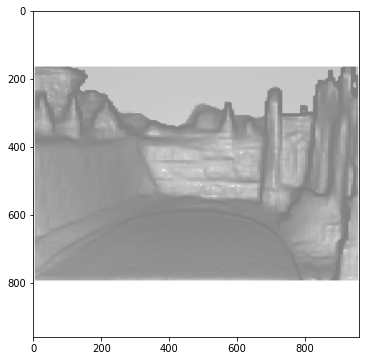

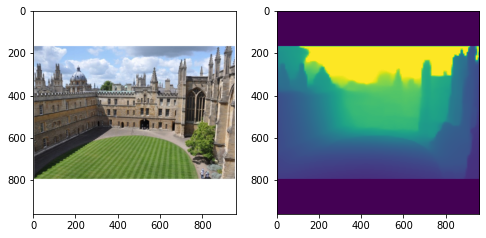

In [7]:
mesh0 = take_mesh_pic(R_init, T_init)
rgb0 = take_pic(R_init, T_init)
cam0 = (R_init, T_init)

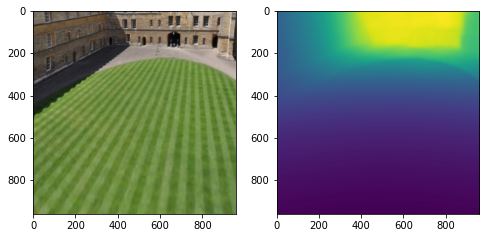

In [8]:
plt.close('all')
cameras = []

R_new, T_new = R_init, T_init
R_new, T_new = move_3d(R_new, T_new, 3, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, -3, cameras)
R_new, T_new = v_rotate(R_new, T_new, -10, cameras)

rgb1 = take_pic(R_new, T_new)
cam1 = (R_new, T_new)

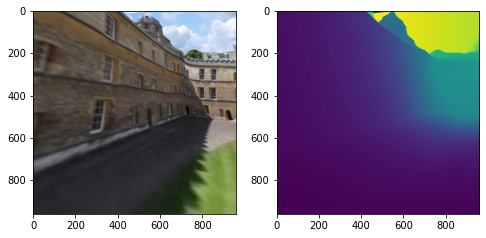

In [9]:
plt.close('all')
cameras = []

R_new, T_new = R_init, T_init
R_new, T_new = rotate(R_new, T_new, -10, cameras)
R_new, T_new = move_3d(R_new, T_new, 3, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, 7, cameras)
R_new, T_new = move_3d(R_new, T_new, -0.6, cameras, fwd_ratio=0, up_ratio=1, right_ratio=0)
R_new, T_new = move_3d(R_new, T_new, 3, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, -5, cameras)

rgb2 = take_pic(R_new, T_new)
cam2 = (R_new, T_new)

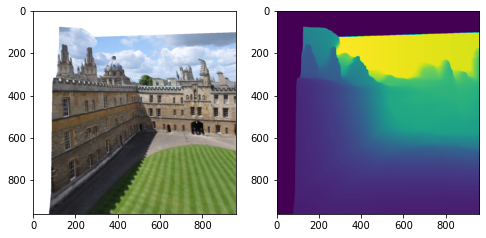

In [10]:
plt.close('all')

R_new, T_new = R_init, T_init
R_new, T_new = rotate(R_new, T_new, -10, cameras)
R_new, T_new = move_3d(R_new, T_new, 3, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, 7, cameras)

rgb3 = take_pic(R_new, T_new)
cam3 = (R_new, T_new)

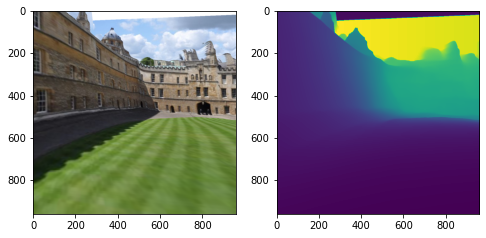

In [11]:
plt.close('all')
cameras = []

R_new, T_new = R_init, T_init
R_new, T_new = rotate(R_new, T_new, -10, cameras)
R_new, T_new = move_3d(R_new, T_new, 3, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, 7, cameras)
R_new, T_new = move_3d(R_new, T_new, -0.8, cameras, fwd_ratio=0, up_ratio=1, right_ratio=0)
R_new, T_new = move_3d(R_new, T_new, 1, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)

rgb4 = take_pic(R_new, T_new)
cam4 = (R_new, T_new)

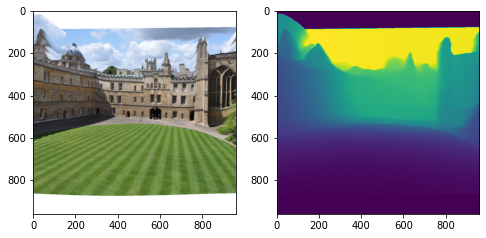

In [12]:
plt.close('all')
cameras = []

R_new, T_new = R_init, T_init
R_new, T_new = move_3d(R_new, T_new, -0.6, cameras, fwd_ratio=0, up_ratio=1, right_ratio=0)
R_new, T_new = move_3d(R_new, T_new, 2.5, cameras, fwd_ratio=1, up_ratio=0, right_ratio=0)
R_new, T_new = rotate(R_new, T_new, -1, cameras)

rgb5 = take_pic(R_new, T_new)
cam5 = (R_new, T_new)

## Make a continuous video by interpolating the camera matrices

In [13]:
frame_size = (image_size, image_size)
frames = []

cameras = []
R_new, T_new = R_init, T_init
interpolate_RT_matrix(*cam0, *cam1, cameras, num=60)
interpolate_RT_matrix(*cam1, *cam4, cameras, num=60)
interpolate_RT_matrix(*cam4, *cam2, cameras, num=60)
interpolate_RT_matrix(*cam2, *cam1, cameras, num=60)
interpolate_RT_matrix(*cam1, *cam0, cameras, num=60)

for r, t in tqdm(cameras):
    rgb_out = take_pic(r, t, show=False)
    if rgb_out.shape[:2] != frame_size:
        rgb_out = skimage.transform.resize(rgb_out, frame_size)

    # float32 -> uint8, RGB -> BGR
    frames.append(skimage.img_as_ubyte(rgb_out[..., ::-1]))

video_file = f"./oxford.mp4"
os.makedirs(os.path.dirname(video_file), exist_ok=True)

fourcc = cv2.VideoWriter_fourcc(*"MP4V")
fps = 30
writer = cv2.VideoWriter(video_file, fourcc, fps, frame_size)

for img in frames:
    writer.write(img)
writer.release()

100%|██████████| 300/300 [01:21<00:00,  3.68it/s]
